# Natural Language Processing - Spam Collection

- Compile Documents
- Featurize them
- Compare features

Imagine Two Documents ('Blue House' and 'Red House')
'Blue House' -> (red,blue,house) -> (0,1,1)
'Red House' -> (red,blue,house) -> (1,0,1)
A document represented as a vector of word counts is a 'bag of words.' You can use the cosine similarity on the vectors to determine similarity (dot product). Improve on Bag of Words by adjusting word counts based on their frequency in corpus (group of all the documents). We can use TF-IDF(Term Frequency - Inverse Document Frequency). 

Term Frequency : importance of the term within that document
- TF(d,t) = # of occurences of term t in document d
Inverse Document Frequency: importance of the term in the corpus
- IDF(t) = log(D/t) where D = total # of documents, t = # of docs within the term

Mathematically, TF-IDF is expressed as:
**(W)x,y = (tf)x,y * log(N/(df)x)**

(tf)x,y = frequence of x in y
(df)x = # of docs containing x
N = total # of docs

For this project we will be using data from [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). 

In [1]:
import nltk

In [2]:
# nltk.download_shell()

The SMS Spam Collection Dataset classifies text as spam or ham (normal text message). We'll use this data to create a spam detection filter with python.

In [4]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

In [5]:
print(len(messages))

5574


In [10]:
messages[42]

'spam\t07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow'

A collection of texts is called a corpus. Let's print the first ten messages and number them using enumerate

In [12]:
for mess_no, message in enumerate(messages[:10]):
    print(mess_no,message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 1

From the spacing we can tell this is a TSV('tab seperated values') file, where the first column is a label saying whether the message is 'ham' or 'spam.' The second column is the message itself. (Our numbers are not parts of the file, they're from the enumerate call).

Using these labeled ham and spam examples, we'll train a machine learning model to classify between ham and spam automatically. Then with this model we can classify arbitrary unlabeled messages as ham or spam.

Let's use pandas to parse this TSV file.

In [14]:
import pandas as pd

In [15]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                      names=['label','message'])

In [16]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [18]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


Let's use groupby to describe by label, this way we can begin to think about the feature that seperate ham and spam.

In [19]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

We need to start thinking about features we're going to be using. This is called features engineering which is a large part of spam direction. Let's make a new column to detect how long the text messages are.

In [20]:
messages['length'] = messages['message'].apply(len)

In [21]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


# Data Visualization

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

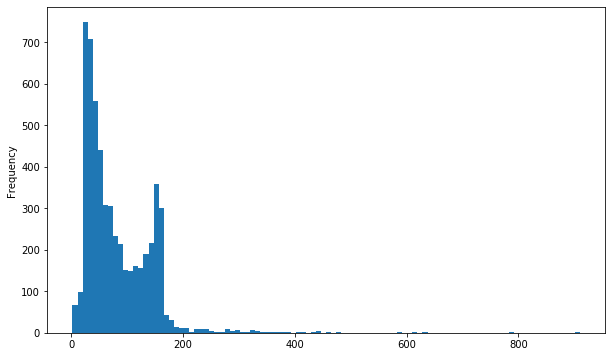

In [26]:
plt.figure(figsize=(10,6))
messages['length'].plot.hist(bins=100)

It seems to be a bimodal distribution. Perhaps text length is a good feature to think about. Let's try to explain why some messages go all the way past 800.

In [27]:
messages.describe()

,length
count,5572.000000
mean,80.489950
std,59.942907
min,2.000000
25%,36.000000
50%,62.000000
75%,122.000000
max,910.000000


In [33]:
messages[messages['length']>=800]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

So the outlier seems to be some sort of love message, and chicken curry. Interesting. Anyways, let's try to get back on track!

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001748077EB00>,
      dtype=object)

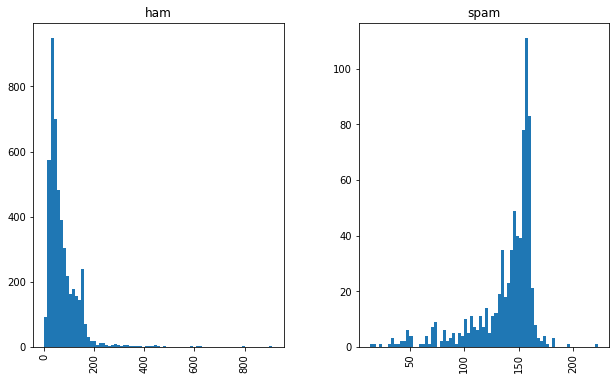

In [34]:
messages.hist(column='length',by='label',bins=75,figsize=(10,6))

Interesting! Spam messages tend to be much more longer than ham messages. 

 # Text Pre-Processing
 
Main issue with the data is that it's all in text format. All the machine leaning algoriths like logistic regression, SVM, etc. needs some sort of numerical feature vector in order to perform the classification task. There are many methods to convert a corpus to a vector format. The simplest is the bag of words approach, where each unique word in a text is represented by one number.
 
We'll convert raw messages (sequence of characters) into vectors (sequences of numbers). Let's first write a function that will split a message into individual words. We'll also remove common words such as ('the', 'a', etc) We will take advantage of the NLTK library. It's the standard library in python for processing text and has a lot of useful features. 

Let's create a function to process the string in the message column, then use apply() in pandas to process all the text into one DataFrame. We'll take advantage of Python's built-in string library to get a quick list of all the possible punctuation.

In [35]:
import string

In [42]:
mess = 'Sample message! Notice: it has punctuation.'
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [47]:
nopunc = [char for char in mess if char not in string.punctuation]

In [48]:
nopunc

['S',
 'a',
 'm',
 'p',
 'l',
 'e',
 ' ',
 'm',
 'e',
 's',
 's',
 'a',
 'g',
 'e',
 ' ',
 'N',
 'o',
 't',
 'i',
 'c',
 'e',
 ' ',
 'i',
 't',
 ' ',
 'h',
 'a',
 's',
 ' ',
 'p',
 'u',
 'n',
 'c',
 't',
 'u',
 'a',
 't',
 'i',
 'o',
 'n']

In [49]:
from nltk.corpus import stopwords

In [50]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

These are very common words that wouldn't be very helpful when we try to distinguish between spam and ham text messages.

In [51]:
nopunc = ''.join(nopunc)
nopunc

'Sample message Notice it has punctuation'

In [56]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [59]:
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [60]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

So to make clean_mess we iterated, word for word in the list nopunc.split() as long as the lowercase version of that word is not in the common stopwords. Notice that it and has, was removed in the clean_mess list.

Now let's put this entire process into a function that we can .apply() to the entire dataframe.

In [68]:
#mess will be the initial string
def text_process(mess):
    """
    1. remove punctuation
    2. remove stopwords
    3. return list of clean text words
    """
    
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [69]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [70]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

# Continuing Normalization

Note that therea are more ways to normalize this text such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

NLTK has built-in tools on these methods, but sometimes don't work well for text-messages due to the way a lot of people tend to use abbreviations/shorthand, for example:
    'Nah dawg, idk! wut time u headin to da club?'

versus
    'No dog, i don't know! What time you heading to the club?'
    
Some text normalization methods has trouble with this type of shorthand. For the purpose of this project we'll just focus on using what we have and convert our list of words to an actual vector that scikit-learn can use.

# Vectorization

Right now, we have messages as tokens and we need to convert each of these messages into a vector that scikit learn's algorith models can work with. We'll convert each message, represented as a list of tokens, into a vector that machine learning can understand.

We'll do that in three steps using the bag of words model:
1. Count how many times a word occurs in each message (term frequency)
2. Weigh the counts, so frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin with the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus. We'll use scikitlearn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-dimensional matric where the 1-dimension is the entire vocabulary (1 row per word) and the other dimesion are actual documents (1 column per text message).

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>

Since there are many messages, there are a lot of zero counts for the presence of that word in the document. SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix) because of this.

In [72]:
from sklearn.feature_extraction.text import CountVectorizer

In [73]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

In [74]:
print(len(bow_transformer.vocabulary_))

11425


In [75]:
mess4 = messages['message'][3]

In [76]:
print(mess4)

U dun say so early hor... U c already then say...


In [77]:
bow4 = bow_transformer.transform([mess4])

In [78]:
print(bow4)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


In [80]:
print(bow4.shape)

(1, 11425)


So basically there are 7 unique words in message 4 and 2 of them appear twice.

In [83]:
bow_transformer.get_feature_names()[4068]

'U'

In [84]:
bow_transformer.get_feature_names()[9554]

'say'

Now we can use .transform on our bag of words transformed object and transfore the entire DataFrame of messages.

In [85]:
messages_bow = bow_transformer.transform(messages['message'])

In [86]:
print('Shape of Sparse Matrix: ', messages_bow.shape)

Shape of Sparse Matrix:  (5572, 11425)


In [88]:
messages_bow.nnz #non zero appearances

50548

After counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidTransformer.

# TF-IDF
TF_IDF stands for term frequency-inverse document frequency, and the tf-idf weight is used in information retrieval and text mining. The weight measures how important a word is to a document in a collection of corpus. The importance increases proportionally to the number of times a wod appears in the document but is offset by the frequency of word in the corpus. Variations of the tf-idf scheme is used by search engines as central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term, and the more sophisticated ranking functions are variations of this model.

The tf-idf weight is composed by two terms. The first computes the normalized Term Frequency (TF) which is the number of times a word appears in the document, divided by the number of words. The second term is inverse document frequency (IDF) which is the logarithm of the number of documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency** Since every document is different in length, it's possible a term would appear much more times in long documents than in shorter ones. So, the term frequency is divided by the document length (# of terms in the document) as a way of normalization.

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency** measures how important a term is. When you compute TF, all terms are considered equally important, however in certain terms such as 'is', 'of', etc, they appear a lot but is of little importance. Thus we need to weigh down the frequent terms while scaling up the rare ones.

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

**EXAMPLE:** Consider a document that has 100 words where cat appears 3 times.

The tf for cat is (3/100) = 0.03. Now if there are 10 million documents and the word cat appears in one thousand of these, then the inverse document is calculated to be log(10 000 000 / 1000) = 4. Thus the tf-idf wieght is the product of these quantities: 0.03*4 = 0.12

Let's implement this with scikit learn!

In [90]:
from sklearn.feature_extraction.text import TfidfTransformer

In [92]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [93]:
tfidf4 = tfidf_transformer.transform(bow4)

In [94]:
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


Let's check the idf of a particular word, like club and beer.

In [98]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['club']])

7.32310369457549


In [101]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['beer']])

8.93254160700959


In [102]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

There are many ways that data can be preprocessed and vectorized. These steps involves feature engineering and building a 'pipeline.'

# Training a model

Now that messages are represented as vectors, we can finally train our spam/ham classifier. We can use almost any classification algorithm but we'll choose to use the Naive Bayes classifier algortihm.

In [103]:
from sklearn.naive_bayes import MultinomialNB

In [105]:
spam_detect_model = MultinomialNB().fit(messages_tfidf,messages['label'])

In [107]:
spam_detect_model.predict(tfidf4)[0] #detects tfidf4 as ham

'ham'

In [108]:
messages['label'][3] #it actually is ham so we're predicting correctly

'ham'

In [109]:
all_pred = spam_detect_model.predict(messages_tfidf)

In [112]:
all_pred

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [117]:
from sklearn.metrics import classification_report
print(classification_report(messages['label'],all_pred))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



So with the current model we accurately detected whether a text message would be spam or ham with up to 98% accuracy! However we evaluated accuracy on the same dataset we used for training, and **you should never evaluate on the same dataset you train on**

This evaluation tells us nothing about the true predictive power of our model. We should split the data into training/test set, where the model only ever sees training data during its model fitting and parameter tuning. The test data is never used. This would be used our final evaluation to represent the true predictive power performance

# Train Test Split

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
msg_train,msg_test,label_train,label_test = train_test_split(messages['message'],messages['label'],test_size=0.3)

In [116]:
msg_train.head()

5000                           Hmph. Go head, big baller.
3830             Sure, I'll see if I can come by in a bit
902           How is it possible to teach you. And where.
1285                         But if she.s drinkin i'm ok.
5112    December only! Had your mobile 11mths+? You ar...
Name: message, dtype: object

#### Data Pipeline
Let's run our model using pipeline to store the pipeline of the workflow. This allows us to set up the transformations that we'll do to data for future use.

In [118]:
from sklearn.pipeline import Pipeline

In [119]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)), #strings to token integer counts
    ('tfidf',TfidfTransformer()), #integer counts to tfidf scores
    ('classifier', MultinomialNB())
])

In [120]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001748AA3E378>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [121]:
pred = pipeline.predict(msg_test)

In [122]:
print(classification_report(label_test,pred))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1462
        spam       1.00      0.71      0.83       210

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.96      1672



Now we have a classification report for our true testing set. We've accurately predicted spam vs ham up to 96% !